## Exploratory Data Analysis

To analyze the data I load up the cifar-10 dataset and
1. find its dimensions
  - 20,000 sample images total
  - 3072 features... images are 32x32 large so 1024 pixels per image. 
  - 3072 = 1024x3 so RGB is already separated
2. plot a random image from the dataset to visualize the data, using matplotlib
3. plot the class distribution from the target vector using seaborn
  - distribution seems pretty even, no particular class is over/under represented
4. plot the pixel value distribution for all pixels
  - pixel values are NOT normalized when loaded up
  - if 0 = dark & 255 = light then...
    - the distribution of pixel values is slightly biased towards darker images
    - there is a spike of light pixels (seems reasonable to have)
  - aside from outliers, the distribution is relatively gaussian, guesstimating mean ~100
5. apply principal component analysis (PCA) 
 - After standardizing data I see a more true Gaussian bell curve for pixel distribution, centered around 0
 - fitted PCA, projected train and test data into lower dimensional space, didn't particularly see much separation between classes

In [13]:
import pandas
import seaborn as sns
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix


In [3]:
# load up data
X, y = fetch_openml('CIFAR_10_small', as_frame=True, return_X_y=True, parser='auto')
#print(X)

# separate into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=27)

# create dict of output to class names according to openml metadata
classes = { 0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [3]:
# check dimensions of data
print(X.shape)
print(y.shape)

(20000, 3072)
(20000,)


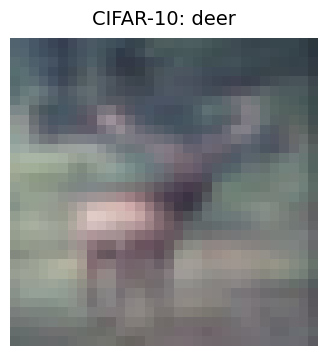

In [4]:
# plotting a random cifar image
sample = np.random.randint(0, X.shape[0])  # generate random number within range of number of samples

def plot_image(index: int):
    record = X.iloc[index, : ].values
    red = record[0:1024].reshape(32, 32) / 255
    green = record[1024:2048].reshape(32, 32) / 255
    blue = record[2048:].reshape(32, 32) / 255

    image = np.dstack((red, green, blue))


    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Display the image using Matplotlib's imshow
    ax.imshow(image)
    # ax.imshow(image, interpolation='bicubic')    # uncomment this line for a 'smoother' looking picture
    ax.axis('off') # remove axis    
    ax.set_title(f'CIFAR-10: {classes[int(y.iloc[index])]}', fontsize=14, pad=10)

    # Show the plot
    plt.show()


plot_image(sample)


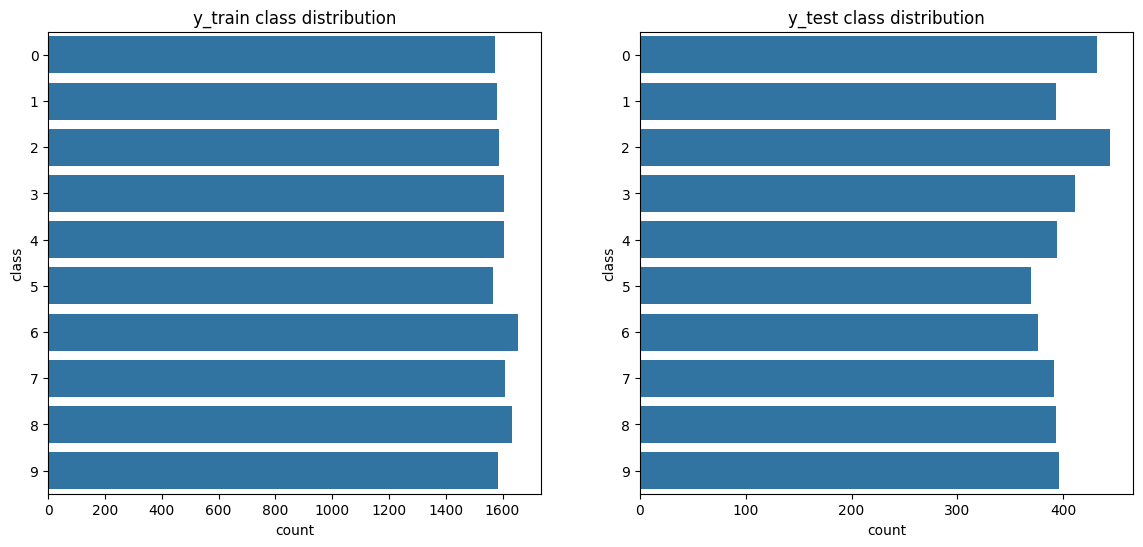

In [16]:
# check distribution of classes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(y_train, ax=axes[0])
axes[0].set_title("y_train class distribution")
sns.countplot(y_test, ax=axes[1])
axes[1].set_title("y_test class distribution")
plt.show()

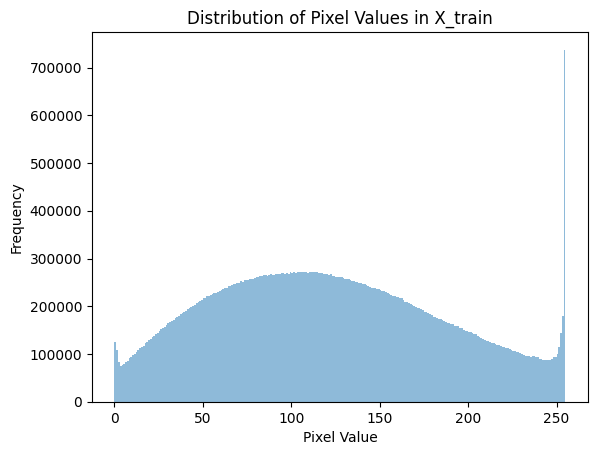

In [5]:
# plot the distribution of pixel values
plt.hist(X_train.values.flatten(), bins=255, alpha=0.5)
plt.title("Distribution of Pixel Values in X_train")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

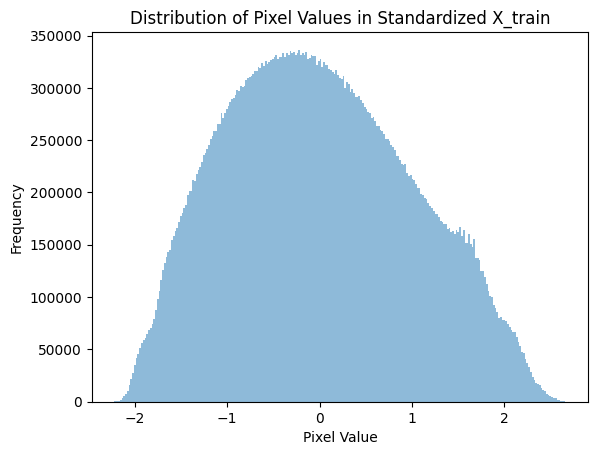

In [11]:
# before applying PCA you must standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)    # 'fit' a standardization for the train data so no test mean and std leaks to model
X_test = scaler.transform(X_test)

# I just wanna see how the distribution of pixels changes after standardization
plt.hist(X_train.flatten(), bins=255, alpha=0.5)
plt.title("Distribution of Pixel Values in Standardized X_train")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

Text(0.5, 1.0, 'PCA of CIFAR-10 Training Data')

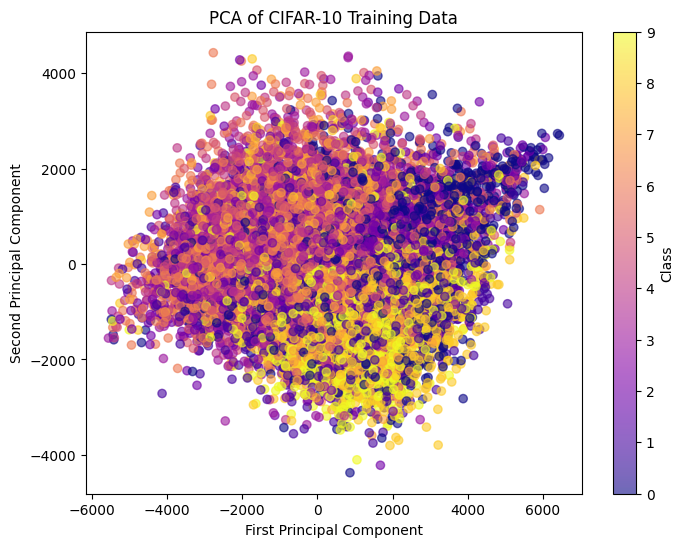

In [5]:
pca = PCA(n_components=3)

X_train_pca = pca.fit_transform(X_train)   # learn principal components from training data
X_test_pca = pca.transform(X_test)        # project test data into same lower-dimensional space as train data

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.astype('int'), cmap='plasma', alpha=0.6)   # plot first two principal components against each other
plt.xlabel('First Principal Component')                       #^ give it classes for coloring        # ^ dot transparency       
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Class')
plt.title('PCA of CIFAR-10 Training Data')


In [6]:
print("Principal Components:\n", pca.components_)

Principal Components:
 [[ 0.02660517  0.02651061  0.02661326 ...  0.01858065  0.01883519
   0.01917558]
 [-0.01609235 -0.01653316 -0.01691711 ...  0.02201548  0.02124661
   0.02058851]
 [-0.02178882 -0.02169267 -0.02153459 ... -0.01562876 -0.01580868
  -0.01600588]]


Text(0.5, 1.0, 'PCA of CIFAR-10 Test Data')

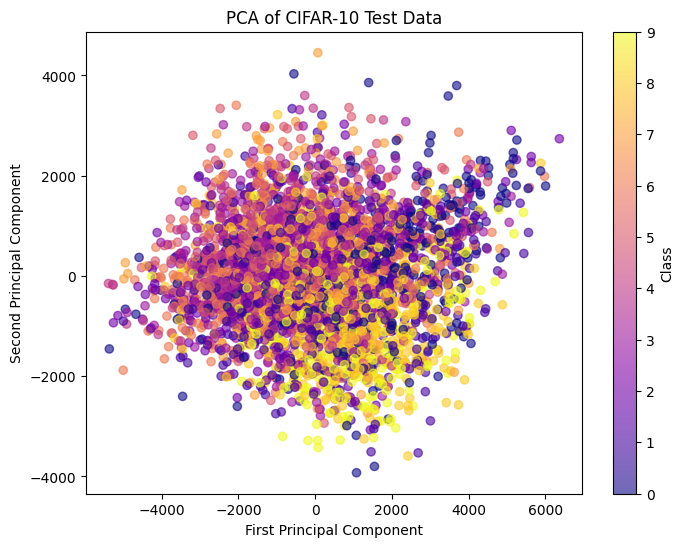

In [12]:
# now plot pca for the test data

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test.astype('int'), cmap='plasma', alpha=0.6)   
plt.xlabel('First Principal Component')                  
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Class')
plt.title('PCA of CIFAR-10 Test Data')

### Logistic Regression
- first using it on PCA projected data, then on unprocessed data

In [8]:
lr = LogisticRegression(penalty=None, C=1.0, solver='saga', multi_class='multinomial',
                                  max_iter=5000, verbose=2, random_state=27)
'''
C = inverse of regularization strength, smaller values specify stronger regularization
penalty = 'l1', 'l2', 'elasticnet', None
tol = tolerance for stopping criteria
max_iter = Maximum number of iterations taken for the solvers to converge.
'''

lr.fit(X_train_pca, y_train)

Epoch 1, change: 1.00000000
Epoch 2, change: 0.26164997
Epoch 3, change: 0.16426576
Epoch 4, change: 0.08948433
Epoch 5, change: 0.10137574
Epoch 6, change: 0.08056280
Epoch 7, change: 0.06023093
Epoch 8, change: 0.01584811
Epoch 9, change: 0.00572538
Epoch 10, change: 0.00431964
Epoch 11, change: 0.00286878
Epoch 12, change: 0.00209222
Epoch 13, change: 0.00032016
Epoch 14, change: 0.00015405
Epoch 15, change: 0.00022469
Epoch 16, change: 0.00014899
convergence after 17 epochs took 0 seconds


LogisticRegression(max_iter=5000, multi_class='multinomial', penalty=None,
                   random_state=27, solver='saga', verbose=2)

In [11]:
# analyze metrics of a logistic regression trained on PCA projected data
labels = [str(x) for x in range(10)]     # this is needed for log_loss calc to play right

y_pred_train_pca = lr.predict_proba(X_train_pca)
loss = log_loss(y_train, y_pred_train_pca, labels = labels)
print(f'Train loss for logistic regression on PCA data is {loss:.3f}')

y_pred_test_pca = lr.predict_proba(X_test_pca)
loss = log_loss(y_test, y_pred_test_pca, labels = labels)
print(f'Test loss for logistic regression on PCA data is {loss:.3f}')

y_pred_test_pca = lr.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred_test_pca, normalize=True)
print(f'Accuracy for the test data is {acc*100:.2f}%')

Train loss for logistic regression on PCA data is 2.108
Test loss for logistic regression on PCA data is 2.127
Accuracy for the test data is 22.82%


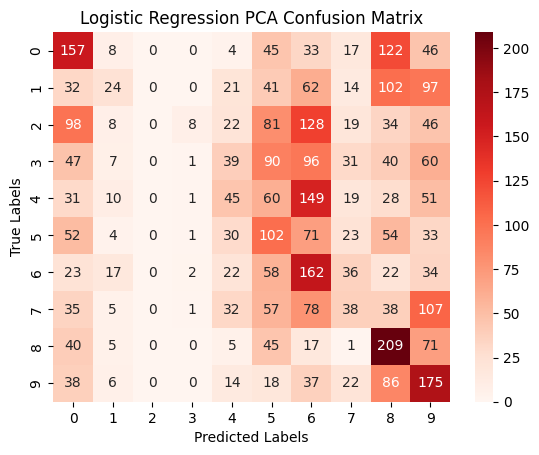

In [18]:
# create a confusion matrix from the pca predictions
cm = confusion_matrix(y_test, y_pred_test_pca)

sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Logistic Regression PCA Confusion Matrix")
plt.show()